In [ ]:
##This notebook is based on https://keras.io/examples/vision/siamese_contrastive/

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Apr  5 10:28:28 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
#mounting google drive on colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_dataset=pd.read_csv('./drive/MyDrive/best_model_28_representation_train_040422.csv').iloc[:,1:]
val_dataset=pd.read_csv('./drive/MyDrive/best_model_28_representation_val_040422.csv').iloc[:,1:]

In [ ]:
train_dataset

,0,1,2,3,4,5,6,7,8,9,...,2039,2040,2041,2042,2043,2044,2045,2046,2047,category_class
0,0.033333,0.313336,0.025133,0.229388,0.136946,0.034979,0.120104,0.196935,0.023299,0.166517,...,0.561781,0.001802,0.210695,0.161759,0.020894,0.524201,0.353692,0.020171,0.403670,338
1,0.093444,0.316758,0.170155,0.137241,0.259935,0.474877,0.000000,0.194750,0.067905,0.051878,...,1.161999,0.064962,0.178196,0.366895,0.073961,0.799406,0.238650,0.013355,0.226344,338
2,0.005281,0.349727,0.094547,0.376952,0.304110,0.114644,0.173896,0.426651,0.051706,0.172470,...,0.607481,0.092371,0.017004,0.155562,0.018352,0.468657,0.072951,0.036000,0.496107,338
3,0.089383,0.107351,0.075641,0.013774,0.096981,0.001354,0.072457,0.125850,0.032342,0.126957,...,0.416517,0.064198,0.024564,0.143060,0.013859,0.805468,0.205996,0.024247,0.788354,338
4,0.013804,0.034383,0.114037,0.031434,0.449520,0.003940,0.158426,0.118010,0.004489,0.047437,...,0.264046,0.103955,0.075154,0.008518,0.005747,0.603387,0.416539,0.005948,0.242247,338
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,0.008469,0.153707,0.295961,0.640903,0.147320,0.107286,0.033159,0.055960,0.008775,0.000215,...,0.466908,0.157604,0.001789,0.313070,0.021882,0.128249,0.420876,0.125631,0.086492,591
39996,0.010601,0.295052,0.014810,0.608878,0.032543,0.013807,0.200572,0.015779,0.207144,0.473168,...,0.044090,0.042290,0.077591,0.028302,0.023190,0.081915,0.164003,0.035183,0.097715,591
39997,0.192546,0.433518,0.085116,0.000000,0.819737,0.000000,0.049733,0.018173,0.015861,0.194425,...,0.000000,0.004095,0.006790,0.154554,0.153198,0.000000,0.522131,0.000262,0.001606,591
39998,0.052466,1.688614,0.070324,0.110022,0.126059,0.000000,0.095915,0.001023,0.010808,0.105967,...,0.000000,0.058327,0.070632,0.421258,0.018547,0.004673,0.220298,0.007178,0.071261,591


In [ ]:
val_dataset

,0,1,2,3,4,5,6,7,8,9,...,2039,2040,2041,2042,2043,2044,2045,2046,2047,category_class
0,0.037247,0.084723,0.067953,0.148163,0.190729,0.034427,0.010865,0.190755,0.040758,0.071579,...,0.413018,0.040352,0.029557,0.017327,0.082976,0.208654,0.213978,0.007254,0.369544,338
1,0.006566,0.147232,0.117783,0.476772,0.533292,0.588703,0.131454,0.441281,0.010310,0.016984,...,0.224854,0.045422,0.151592,0.346858,0.000291,0.781311,0.047355,0.008029,0.237799,338
2,0.210000,0.083216,0.107389,0.373491,0.139399,0.228461,0.224466,0.400738,0.035322,0.065952,...,0.340572,0.006806,0.127561,0.045913,0.742372,0.063517,0.105330,0.058667,0.092687,338
3,0.089227,0.028722,0.023529,0.516543,0.357591,1.165964,0.149411,0.075871,0.022748,0.000000,...,0.272945,0.010554,1.335347,0.072965,0.002853,0.189264,0.011270,0.085637,0.058687,338
4,0.005663,0.135440,0.112919,0.115065,0.094258,0.071284,0.024563,0.129603,0.003601,0.212501,...,0.402290,0.103481,0.176257,0.158090,0.010789,0.546413,0.319652,0.083233,0.016363,338
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.000638,0.113700,0.108743,0.090572,0.055815,0.000000,0.082937,0.025062,0.003649,0.045059,...,0.713404,0.000000,0.009588,0.051383,0.411699,0.089952,0.282519,0.000132,0.007038,591
9996,0.059231,0.211131,0.201713,0.032353,0.048716,0.000000,0.000000,0.077469,0.013222,0.060250,...,0.411932,0.000000,0.000043,0.028635,0.034902,0.292674,0.112189,0.008453,0.048728,591
9997,0.001761,1.463821,0.011850,0.032598,0.937367,0.021707,0.103139,0.006572,0.019002,0.021300,...,0.000000,0.009892,0.071254,0.661938,0.006536,0.265005,0.174313,0.000492,0.299318,591
9998,0.026339,0.870153,0.044403,0.028958,0.081213,0.000000,0.152911,0.002433,0.006991,0.132442,...,0.021862,0.001303,0.022319,0.043793,0.260402,0.007712,0.034186,0.000000,0.067226,591


In [ ]:
from collections import Counter
len(Counter(train_dataset['category_class']))

1000

In [ ]:
x_train=train_dataset.iloc[:,:-1].values
y_train=train_dataset.iloc[:,-1].values
x_val=val_dataset.iloc[:,:-1].values
y_val=val_dataset.iloc[:,-1].values

In [ ]:
y_val

array([338, 338, 338, ..., 591, 591, 591])

In [ ]:

input = layers.Input((2048))
x = tf.keras.layers.BatchNormalization()(input)
x=layers.Dropout(0.2)(x)
x = layers.Dense(1000)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = layers.Dense(1000, activation="tanh")(x)
embedding_network = keras.Model(input, x)

def add_projection_head(encoder):
    inputs = keras.Input(shape=(2048))
    features = encoder(inputs)
    outputs = layers.Dense(128, activation="relu")(features)
    model = keras.Model(
        inputs=inputs, outputs=outputs, name="encoder_with_projection-head"
    )
    return model

embedding_with_projection_head = add_projection_head(embedding_network)


In [ ]:
!pip install tensorflow-addons
import tensorflow_addons as tfa

In [ ]:
class SupervisedContrastiveLoss(keras.losses.Loss):
    def __init__(self, temperature=1, name=None):
        super(SupervisedContrastiveLoss, self).__init__(name=name)
        self.temperature = temperature

    def __call__(self, labels, feature_vectors, sample_weight=None):
        # Normalize feature vectors
        feature_vectors_normalized = tf.math.l2_normalize(feature_vectors, axis=1)
        # Compute logits
        logits = tf.divide(
            tf.matmul(
                feature_vectors_normalized, tf.transpose(feature_vectors_normalized)
            ),
            self.temperature,
        )
        return tfa.losses.npairs_loss(tf.squeeze(labels), logits)


In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("./drive/MyDrive/Supercontrastive_040422.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)


earlystop = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', # value being monitored for improvement
                          min_delta = 0, #Abs value and is the min change required before we stop
                          patience = 50, #Number of epochs we wait before stopping 
                          verbose = 1,
                          restore_best_weights = True) #keeps the best weigths once stopped
def scheduler(epoch, lr):
  return(0.1*(0.1 ** (epoch // 30)))

lr_scheduler=tf.keras.callbacks.LearningRateScheduler(scheduler,verbose=1)
# we put our call backs into a callback list
callbacks = [earlystop,checkpoint,lr_scheduler]


In [ ]:
embedding_network.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 2048)]            0         
                                                                 
 batch_normalization_16 (Bat  (None, 2048)             8192      
 chNormalization)                                                
                                                                 
 dropout_9 (Dropout)         (None, 2048)              0         
                                                                 
 dense_20 (Dense)            (None, 1000)              2049000   
                                                                 
 batch_normalization_17 (Bat  (None, 1000)             4000      
 chNormalization)                                                
                                                                 
 dense_21 (Dense)            (None, 1000)              100

In [ ]:
embedding_with_projection_head.compile(loss=SupervisedContrastiveLoss(temperature=0.05), optimizer=tfa.optimizers.SGDW(learning_rate=0.1, momentum=0.9, nesterov=False,weight_decay=1e-4))
embedding_with_projection_head.summary()


Model: "encoder_with_projection-head"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 2048)]            0         
                                                                 
 model_10 (Functional)       (None, 1000)              3062192   
                                                                 
 dense_22 (Dense)            (None, 128)               128128    
                                                                 
Total params: 3,190,320
Trainable params: 3,184,224
Non-trainable params: 6,096
_________________________________________________________________


In [ ]:
history = embedding_with_projection_head.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    batch_size=32,
    epochs=200,verbose=1,callbacks=callbacks
)


Epoch 1: LearningRateScheduler setting learning rate to 0.1.
Epoch 1/200
1249/1250 [============================>.] - ETA: 0s - loss: 0.1469
Epoch 1: val_loss improved from inf to 6.60713, saving model to ./drive/MyDrive/Supercontrastive_040422.h5
1250/1250 [==============================] - 6s 4ms/step - loss: 0.1468 - val_loss: 6.6071 - lr: 0.1000

Epoch 2: LearningRateScheduler setting learning rate to 0.1.
Epoch 2/200
1246/1250 [============================>.] - ETA: 0s - loss: 0.1406
Epoch 2: val_loss improved from 6.60713 to 6.15446, saving model to ./drive/MyDrive/Supercontrastive_040422.h5
1250/1250 [==============================] - 6s 5ms/step - loss: 0.1406 - val_loss: 6.1545 - lr: 0.1000

Epoch 3: LearningRateScheduler setting learning rate to 0.1.
Epoch 3/200
1247/1250 [============================>.] - ETA: 0s - loss: 0.1350
Epoch 3: val_loss improved from 6.15446 to 5.91755, saving model to ./drive/MyDrive/Supercontrastive_040422.h5
1250/1250 [==========================

In [ ]:
results = embedding_with_projection_head.evaluate(x_val, y_val)
print("val loss, val acc:", results)

313/313 [==============================] - 1s 2ms/step - loss: 4.5444
val loss, val acc: 4.544417858123779


In [ ]:
x_train_embedding=embedding_network.predict(x_train)
x_val_embedding=embedding_network.predict(x_val)

In [ ]:
x_train_embedding.shape

(40000, 1000)

In [ ]:
inputs_final = keras.Input(shape=(1000))
x = keras.layers.Dropout(0.2)(inputs_final)  # Regularize with dropout
# x=keras.layers.Dense(1000)(x)
# x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(1000,activation='softmax')(x)
model = keras.Model(inputs_final, outputs)

model.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 1000)]            0         
                                                                 
 dropout_10 (Dropout)        (None, 1000)              0         
                                                                 
 dense_23 (Dense)            (None, 1000)              1001000   
                                                                 
Total params: 1,001,000
Trainable params: 1,001,000
Non-trainable params: 0
_________________________________________________________________


In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("./drive/MyDrive/SGD_supervised_contrastive_embeddings_transferLearning2.h5",
                             monitor="val_accuracy",
                             mode="max",
                             save_best_only = True,
                             verbose=1)


earlystop = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', # value being monitored for improvement
                          min_delta = 0, #Abs value and is the min change required before we stop
                          patience = 50, #Number of epochs we wait before stopping 
                          verbose = 1,
                          restore_best_weights = True) #keeps the best weigths once stopped
def scheduler(epoch, lr):
  return(0.1*(0.1 ** (epoch // 30)))

lr_scheduler=tf.keras.callbacks.LearningRateScheduler(scheduler,verbose=1)
# we put our call backs into a callback list
callbacks = [earlystop,checkpoint,lr_scheduler]


In [ ]:
model.compile(optimizer= tfa.optimizers.SGDW(learning_rate=0.1, momentum=0.9, nesterov=False,weight_decay=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
#onehotencoding
y_train1=np.eye(1000)[y_train]
y_val1=np.eye(1000)[y_val]

In [ ]:
history1 = model.fit(x_train_embedding,
    y_train1,
    validation_data=(x_val_embedding, y_val1),
    batch_size=32,
    epochs=200,verbose=1,callbacks=callbacks
)


Epoch 1: LearningRateScheduler setting learning rate to 0.1.
Epoch 1/200
1244/1250 [============================>.] - ETA: 0s - loss: 6.3652 - accuracy: 0.0475
Epoch 1: val_accuracy improved from -inf to 0.11910, saving model to ./drive/MyDrive/SGD_supervised_contrastive_embeddings_transferLearning2.h5
1250/1250 [==============================] - 5s 4ms/step - loss: 6.3627 - accuracy: 0.0476 - val_loss: 5.8487 - val_accuracy: 0.1191 - lr: 0.1000

Epoch 2: LearningRateScheduler setting learning rate to 0.1.
Epoch 2/200
1241/1250 [============================>.] - ETA: 0s - loss: 5.5733 - accuracy: 0.1115
Epoch 2: val_accuracy improved from 0.11910 to 0.14740, saving model to ./drive/MyDrive/SGD_supervised_contrastive_embeddings_transferLearning2.h5
1250/1250 [==============================] - 4s 3ms/step - loss: 5.5719 - accuracy: 0.1115 - val_loss: 5.2882 - val_accuracy: 0.1474 - lr: 0.1000

Epoch 3: LearningRateScheduler setting learning rate to 0.1.
Epoch 3/200
1247/1250 [==========

In [ ]:
model.evaluate(x_val_embedding,y_val1)

313/313 [==============================] - 1s 3ms/step - loss: 4.4409 - accuracy: 0.2331


[4.440878868103027, 0.23309999704360962]

In [ ]:

def display_learning_curves(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(history.history["loss"])
    ax1.plot(history.history["val_loss"])
    ax1.legend(["train", "valid"], loc="upper right")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")

    ax2.plot(history.history["accuracy"])
    ax2.plot(history.history["val_accuracy"])
    ax2.legend(["train", "valid"], loc="upper right")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy")
    plt.show()


KeyError: ignored

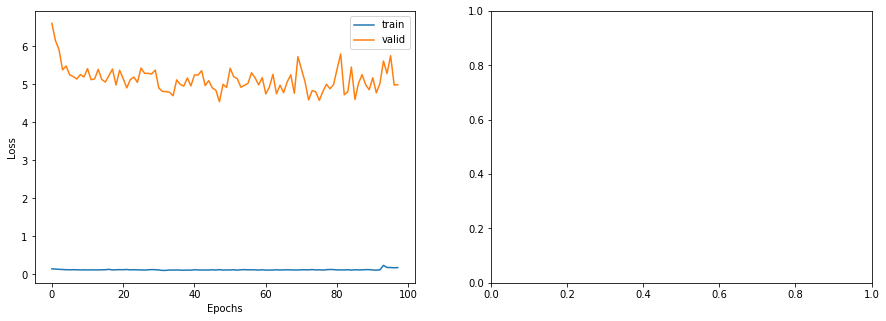

In [ ]:
display_learning_curves(history)

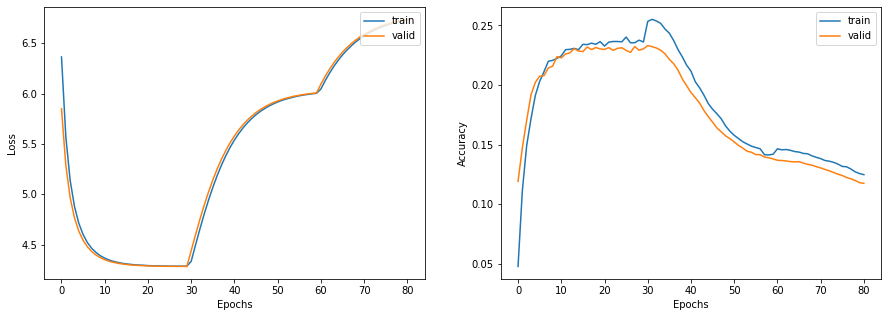

In [ ]:
display_learning_curves(history1)

In [ ]:
embedding_network.save('./drive/MyDrive/SGD_Supervised_contrastive_embeddings.h5')

In [ ]:
temp1=tf.keras.models.load_model('./drive/MyDrive/SGD_Supervised_contrastive_embeddings.h5')
temp2=tf.keras.models.load_model('./drive/MyDrive/SGD_supervised_contrastive_embeddings_transferLearning2.h5')

In [ ]:
temp2.evaluate(temp1.predict(x_val),y_val1)

313/313 [==============================] - 1s 3ms/step - loss: 4.4409 - accuracy: 0.2331


[4.440878868103027, 0.23309999704360962]

In [ ]:
test_dataset=pd.read_csv('./drive/MyDrive/test_representation.csv')

In [ ]:
test_dataset

,0,1,2,3,4,5,6,7,8,9,...,2039,2040,2041,2042,2043,2044,2045,2046,2047,category_class
0,0.000000,0.000000,0.029340,0.959396,0.032180,0.007271,0.505135,0.047305,0.046234,0.000000,...,0.160508,0.108298,0.000000,0.031925,0.008031,0.129452,0.450996,0.004531,0.008310,65.0
1,0.018695,0.131584,0.000580,0.265691,0.075151,0.005068,0.164080,0.603745,0.167325,0.076654,...,0.029152,0.214970,0.000000,0.043662,0.057358,0.093535,0.103441,0.011182,0.052681,970.0
2,0.008372,0.236403,0.014399,0.041888,0.024327,0.042268,0.086519,0.659389,0.053838,0.071150,...,0.135679,0.000000,0.235405,0.324949,0.021558,0.093964,0.012577,0.001841,0.246740,230.0
3,0.169781,0.011046,0.054933,1.199504,0.027333,0.123167,0.185943,0.762185,0.053278,0.096448,...,0.148584,0.007761,0.816408,0.135283,0.010906,0.306520,1.403771,0.235088,0.000832,809.0
4,0.050206,0.857661,0.150167,0.052228,0.291346,0.206538,0.145282,0.104864,0.128827,0.380020,...,0.163841,0.060867,0.049904,0.576424,0.294275,0.000000,0.080127,0.016386,0.423166,516.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,0.002047,0.012996,0.043287,0.194361,0.340890,0.095029,0.137551,0.295975,0.000093,0.009103,...,0.101937,0.010900,0.057891,0.205408,0.010592,1.026036,0.037057,0.005353,1.050666,283.0
49996,0.028609,0.000027,0.154415,1.012217,0.000856,0.078721,0.403259,0.151994,0.003251,0.013472,...,0.033227,0.268508,0.017099,0.000700,0.121087,0.025590,1.007298,0.013507,0.169299,26.0
49997,0.031759,0.009449,0.047738,0.047382,0.949164,0.059264,0.016978,0.000756,0.020112,0.000000,...,0.354629,0.000000,0.229080,0.020603,0.000000,0.809951,0.017986,0.058925,0.459367,232.0
49998,0.008271,0.562913,0.022252,0.110028,0.601711,0.062303,0.476841,0.167790,0.086034,0.083120,...,0.269349,0.010813,0.312314,0.175110,0.289860,0.014819,0.304625,0.050381,0.012309,982.0


In [ ]:
x_test=test_dataset.iloc[:,:-1].values
y_test=test_dataset.iloc[:,-1].values

In [ ]:
y_test=y_test.astype(int)

In [ ]:
y_test1=np.eye(1000)[y_test]

In [ ]:
temp2.evaluate(temp1.predict(x_test),y_test1)

1563/1563 [==============================] - 4s 3ms/step - loss: 4.7508 - accuracy: 0.1608


[4.75075101852417, 0.16082000732421875]